# Tensor-network pulse-level simulations using Quimb

In this notebook, we realize noise-accurate large-scale simulation of a quantum circuit preparing a cluster state. This circuit is composed of an Hadamard gate on all qubits, followed by a CZ on each pair of qubits, in our 1D layout.

In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qiskit as qi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first define our hardware specifications as a function of the number of qubits. We define a function that creates the PulseCircuit object of the cluster circuit

In [ ]:
from spin_pulse import HardwareSpecs, PulseCircuit, Shape

B_field, delta, J_coupling = 0.3, 0.3, 0.03
ramp_duration = 5


def get_hardware_specs(num_qubits):
    return HardwareSpecs(
        num_qubits, B_field, delta, J_coupling, Shape.GAUSSIAN, ramp_duration
    )

In [4]:
def get_pulse_circuit(num_qubits, exp_env=None):
    qreg = qi.QuantumRegister(num_qubits)
    circ = qi.QuantumCircuit(qreg)
    for i in range(num_qubits):
        circ.h(i)
    for i in range(0, num_qubits - 1, 2):
        circ.cz(i, i + 1)
    for i in range(1, num_qubits - 1, 2):
        circ.cz(i, i + 1)

    hardware_specs = get_hardware_specs(num_qubits)
    isa_circ = hardware_specs.gate_transpile(circ)
    return PulseCircuit.from_circuit(isa_circ, hardware_specs, exp_env=exp_env)

    # circ.draw('mpl')

We can show an example of pulse circuit, here with 100 qubits. Recall that no actual simulation of the full quantum circuit has been realized at this point. We have simply generated the form of the pulses that are needed to implement each gate.

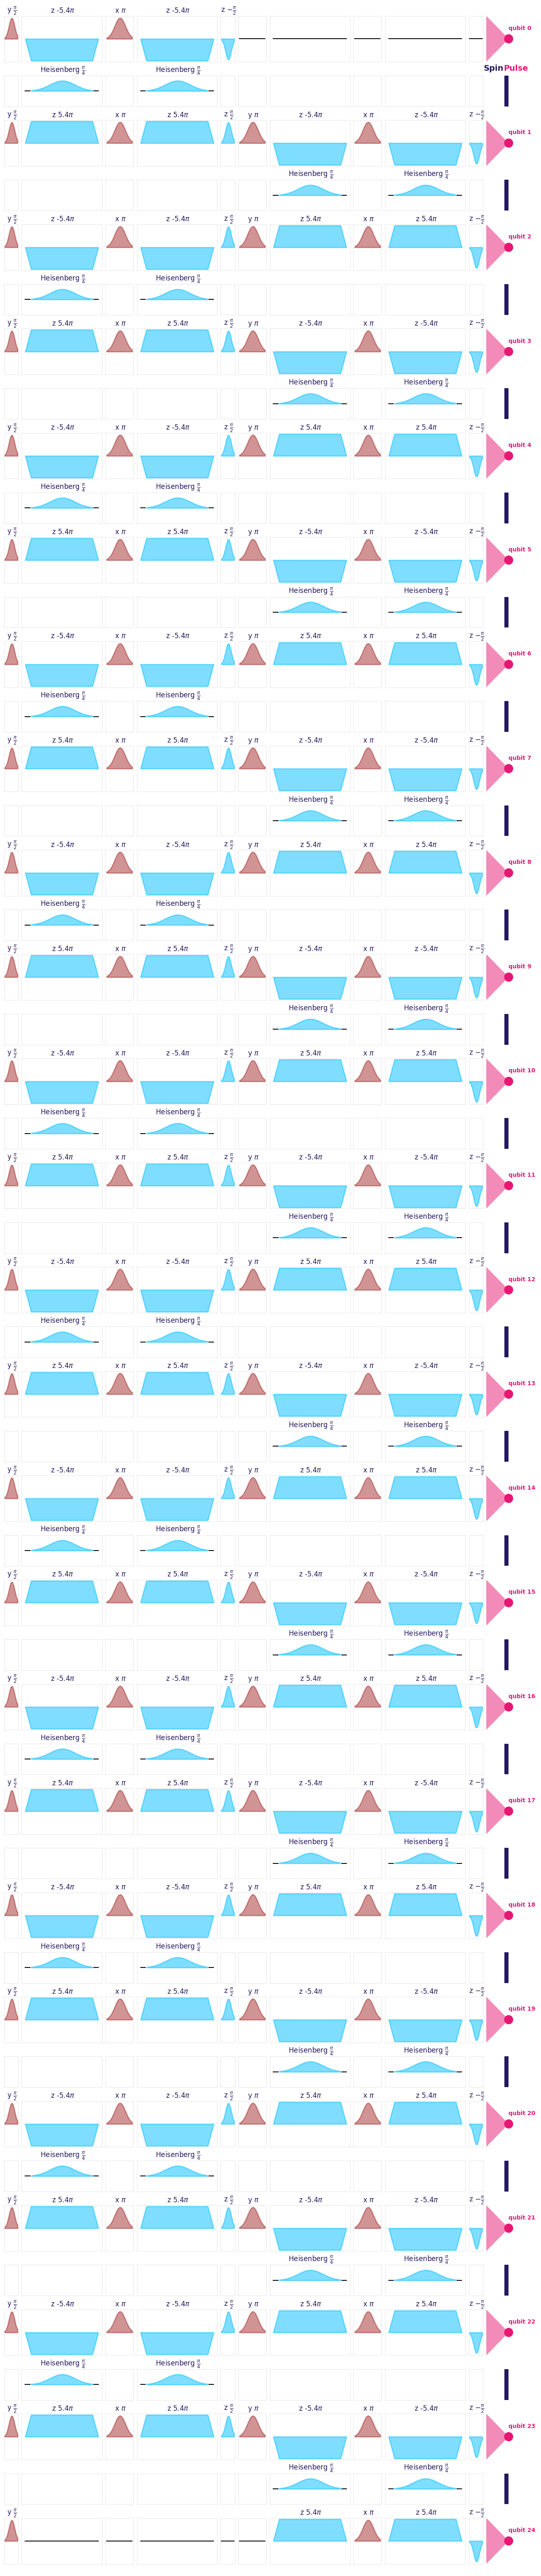

In [5]:
num_qubits = 25
pulse_circuit = get_pulse_circuit(num_qubits)
pulse_circuit.plot(get_hardware_specs(num_qubits))

Our pulse circuit can be converted to gate-based description by calculating the unitary operator associator with each pulse. These unitaries are $2\times2$ or $4\times 4$ matrices, depending whether a pulse acts on one or two qubits.

In [6]:
implemented_circ = pulse_circuit.to_circuit()
print(
    "The first gate of our circuit is described by the unitary matrix ",
    implemented_circ.data[0],
)

The first gate of our circuit is described by the unitary matrix  CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[ 0.70710678+0.j, -0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])]), qubits=(<Qubit register=(25, "q"), index=0>,), clbits=())


These unitary matrices can be loaded into any gate-based simulation. Here we illustrate this possiblity by loading our Qiskit circuit to Quimb and perform tensor-network simulations.

In [7]:
from quimb.tensor import CircuitMPS
from quimb.tensor.circuit import register_constant_gate


def deshuffle_qiskit(mat):
    d = mat.shape[0]
    mymat = np.zeros_like(mat)
    n_bits = int(np.log2(d))
    for i in range(d):
        i_bin = format(i, f"0{n_bits}b")
        i_bin_p = i_bin[::-1]
        i_p = int(i_bin_p, 2)
        for j in range(d):
            j_bin = format(j, f"0{n_bits}b")
            j_bin_p = j_bin[::-1]
            j_p = int(j_bin_p, 2)
            mymat[i_p, j_p] = mat[i, j]
    return mymat


def qiskit_to_quimb(circuit):
    tot_qbs = circuit.num_qubits
    quimb_circ = CircuitMPS(tot_qbs)
    for ins in circuit.data:
        n_qb = len(ins.qubits)
        if n_qb == 1:
            register_constant_gate("NOISY", num_qubits=len(ins.qubits), G=ins.matrix)
            quimb_circ.apply_gate(
                "noisy", qubits=[circuit.qubits.index(q) for q in ins.qubits]
            )
        else:
            register_constant_gate(
                "NOISY", num_qubits=len(ins.qubits), G=deshuffle_qiskit(ins.matrix)
            )
            quimb_circ.apply_gate(
                "noisy", qubits=[circuit.qubits.index(q) for q in ins.qubits]
            )
    return quimb_circ

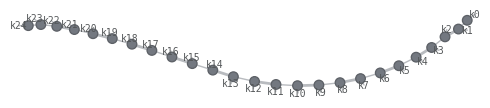

In [9]:
quimb_circ = qiskit_to_quimb(pulse_circuit.to_circuit())
quimb_circ.psi.draw(show_inds=True)

To assess the level of performance of our pulse-level simulation, we will calculate the state fidelity between the exact cluster state wave-function, calculated using a Quimb "ideal" circuit, and the wavefunction obtained through the whole pulse-level decomposition and integration. Note that the fidelity is calculated efficiently in the tensor-network framework as the overlap between two matrix-product-states. 

In [10]:
def get_quimb_circ_ideal(num_qubits):
    quimb_circ_ideal = CircuitMPS(num_qubits)
    for i in range(num_qubits):
        quimb_circ_ideal.apply_gate("H", i)
    for i in range(num_qubits - 1):
        quimb_circ_ideal.apply_gate("CZ", i, i + 1)
    return quimb_circ_ideal


def my_quimb_fidelity(pulse_circuit, quimb_circ_ideal):
    quimb_circ = qiskit_to_quimb(pulse_circuit.to_circuit())
    psi_ideal = quimb_circ_ideal.psi
    psi = quimb_circ.psi
    return np.abs(psi_ideal.H @ psi) ** 2

Without noise, the fidelity deviates only slightly from unity due to small non-adiabatic effects in the realization of the two-qubit gate

In [11]:
quimb_circ_ideal = get_quimb_circ_ideal(num_qubits)
print("Quimb fidelity ", my_quimb_fidelity(pulse_circuit, quimb_circ_ideal))

Quimb fidelity  0.999979902427231


Adding a noise-model, the fidelity gets quickly degraded for large-qubit number

In [ ]:
from spin_pulse.experimental_environment import ExperimentalEnvironment
from spin_pulse.noise import NoiseType

hardware_specs = get_hardware_specs(num_qubits)
exp_env = ExperimentalEnvironment(
    hardware_specs, NoiseType.PINK, T2=1000, duration=2**14, segment_duration=2**14
)

In [14]:
print(
    "Averaged Quimb fidelity ",
    pulse_circuit.averaging_over_samples(my_quimb_fidelity, exp_env, quimb_circ_ideal),
)

100%|██████████| 46/46 [00:24<00:00,  1.91it/s]

Averaged Quimb fidelity  0.9529107548399578


Let us conclude this notebook by a scaling analysis of the fidelity as a function of number of qubits and coherence time $T_2$.

In [ ]:
num_qubits = [10, 20, 50, 100]
T2 = [100, 200, 300, 400]
nx = len(num_qubits)
ny = len(T2)
Fidelity = np.zeros((nx, ny))
for ix in range(nx):
    hardware_specs_ix = get_hardware_specs(num_qubits[ix])
    quimb_circ_ideal = get_quimb_circ_ideal(num_qubits[ix])
    pulse_circuit = get_pulse_circuit(num_qubits[ix])
    for iy in range(ny):
        exp_env = ExperimentalEnvironment(
            hardware_specs_ix,
            NoiseType.PINK,
            T2=T2[iy],
            duration=2**14,
            segment_duration=2**14,
        )
        Fidelity[ix, iy] = pulse_circuit.averaging_over_samples(
            my_quimb_fidelity, exp_env, quimb_circ_ideal
        )
        print(f"N={num_qubits[ix]} T_2={T2[iy]}")  # \mathcal{F}={Fidelity[ix,iy]}$")

100%|██████████| 46/46 [00:06<00:00,  7.24it/s]


N=10 T_2=100


100%|██████████| 46/46 [00:06<00:00,  7.36it/s]


N=10 T_2=200


100%|██████████| 46/46 [00:07<00:00,  6.29it/s]


N=10 T_2=300


100%|██████████| 46/46 [00:07<00:00,  6.55it/s]


N=10 T_2=400


100%|██████████| 46/46 [00:11<00:00,  3.93it/s]


N=20 T_2=100


100%|██████████| 46/46 [00:13<00:00,  3.46it/s]


N=20 T_2=200


100%|██████████| 46/46 [00:12<00:00,  3.79it/s]


N=20 T_2=300


100%|██████████| 46/46 [00:13<00:00,  3.38it/s]


N=20 T_2=400


We observe that the fidelity decays as $\sim\exp(-\alpha N/T_2^2)$. The exponential decay of the fidelity can be understood that each gate is independent affected by the noise, and we attribute the Gaussian dependence $\exp(-\alpha/T_2^2)$ as an effective single qubit fidelity.

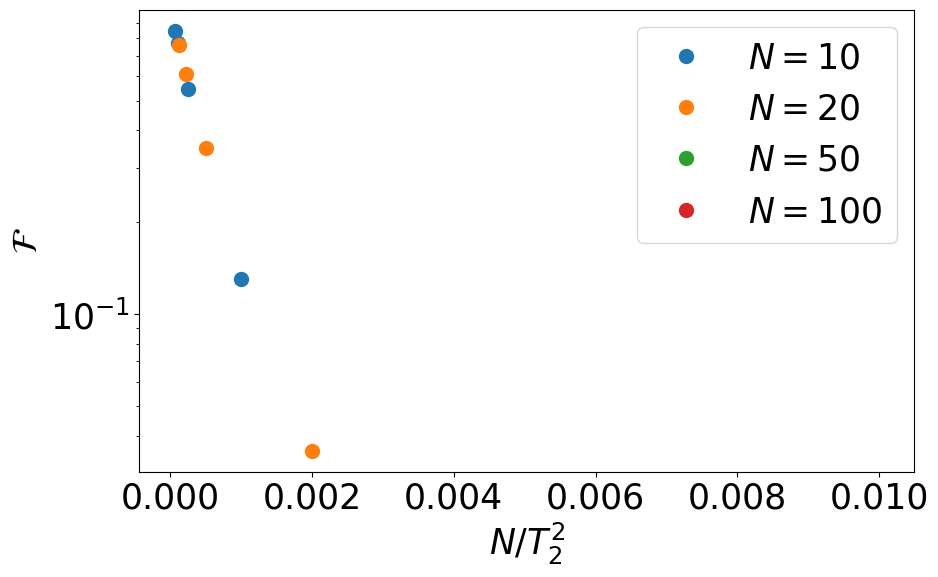

In [22]:
mpl.rcParams["font.size"] = 25
plt.figure(figsize=(10, 6))
for ix in range(nx):
    plt.plot(
        num_qubits[ix] / np.array(T2) ** 2,
        Fidelity[ix, :],
        "o",
        label=f"$N={num_qubits[ix]}$",
        ms=10,
    )
plt.xlabel("$N/T_2^2$")
plt.ylabel(r"$\mathcal{F}$")
plt.legend(loc=0)
plt.yscale("log")
# plt.savefig('../paper/fig5.pdf',bbox_inches='tight')

With white noise, the single qubit fidelity dependence becomes, as expected, dependence $\exp(-\alpha/T_2)$

In [ ]:
num_qubits = [10, 20, 50, 100]
T2 = [500, 1000, 2000, 4000]
nx = len(num_qubits)
ny = len(T2)
Fidelity = np.zeros((nx, ny))
for ix in range(nx):
    hardware_specs_ix = get_hardware_specs(num_qubits[ix])
    quimb_circ_ideal = get_quimb_circ_ideal(num_qubits[ix])
    pulse_circuit = get_pulse_circuit(num_qubits[ix])
    for iy in range(ny):
        exp_env = ExperimentalEnvironment(
            hardware_specs_ix,
            NoiseType.WHITE,
            T2=T2[iy],
            duration=2**14,
            segment_duration=1,
        )
        Fidelity[ix, iy] = pulse_circuit.averaging_over_samples(
            my_quimb_fidelity, exp_env, quimb_circ_ideal
        )
        print(f"$N={num_qubits[ix]} T_2={T2[iy]}")  # \mathcal{F}={Fidelity[ix,iy]}$")

100%|██████████| 46/46 [00:05<00:00,  7.69it/s]


$N=10 T_2=500


100%|██████████| 46/46 [00:06<00:00,  7.06it/s]


$N=10 T_2=1000


100%|██████████| 46/46 [00:06<00:00,  6.92it/s]


$N=10 T_2=2000


100%|██████████| 46/46 [00:07<00:00,  6.40it/s]


$N=10 T_2=4000


100%|██████████| 46/46 [00:11<00:00,  3.93it/s]


$N=20 T_2=500


100%|██████████| 46/46 [00:13<00:00,  3.53it/s]


$N=20 T_2=1000


100%|██████████| 46/46 [00:13<00:00,  3.29it/s]


$N=20 T_2=2000


100%|██████████| 46/46 [00:13<00:00,  3.40it/s]


$N=20 T_2=4000


100%|██████████| 46/46 [00:28<00:00,  1.59it/s]


$N=50 T_2=500


100%|██████████| 46/46 [00:28<00:00,  1.60it/s]


$N=50 T_2=1000


100%|██████████| 46/46 [00:27<00:00,  1.69it/s]


$N=50 T_2=2000


100%|██████████| 46/46 [00:32<00:00,  1.40it/s]


$N=50 T_2=4000


100%|██████████| 46/46 [00:55<00:00,  1.21s/it]


$N=100 T_2=500


100%|██████████| 46/46 [00:53<00:00,  1.16s/it]


$N=100 T_2=1000


100%|██████████| 46/46 [00:55<00:00,  1.20s/it]


$N=100 T_2=2000


100%|██████████| 46/46 [01:02<00:00,  1.36s/it]

$N=100 T_2=4000


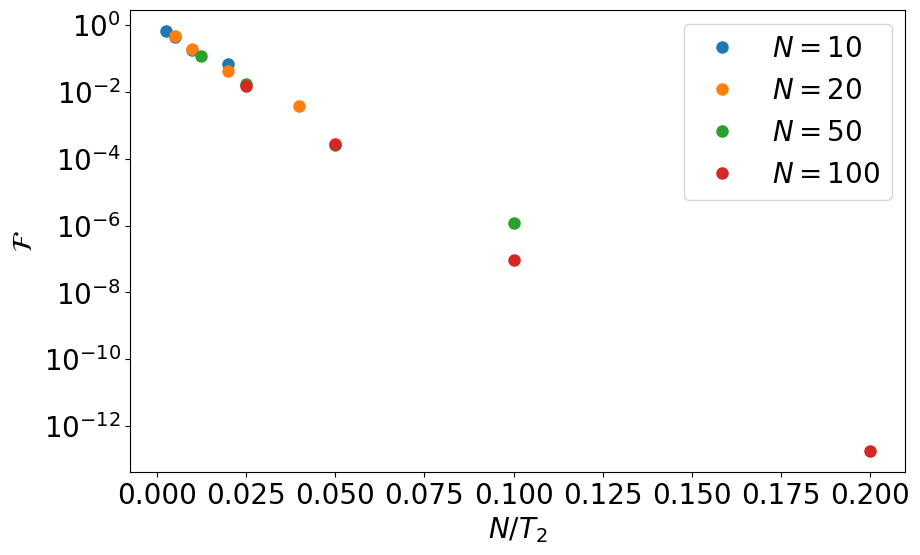

In [24]:
mpl.rcParams["font.size"] = 20
plt.figure(figsize=(10, 6))
for ix in range(nx):
    plt.plot(
        num_qubits[ix] / np.array(T2),
        Fidelity[ix, :],
        "o",
        label=f"$N={num_qubits[ix]}$",
        ms=8,
    )
plt.xlabel("$N/T_2$")
plt.ylabel(r"$\mathcal{F}$")
plt.legend(loc=0)
plt.yscale("log")